# Extract one clean route from citywide 3-month dump

#### PREPARING THE CITYWIDE CSV FILE

1. Dump a CSV from `buses_merged` in the local database using

```
SELECT timestamp, service_date, hour(timestamp), minute(timestamp), route_short, direction, vehicle_id, lat, lon, next_stop_id, next_stop_d, next_stop_d_along_route, passenger_count
FROM buses_merged
WHERE service_date
BETWEEN '2021-04-01' AND '2021-06-30'
INTO OUTFILE '/Users/anthonytownsend/PyCharm Projects/tmp/nn_dump.csv'
FIELDS TERMINATED BY ','
ENCLOSED BY '"'
LINES TERMINATED BY '\n';
```

2. Create the following file...

```
header.csv

timestamp,service_date,hour,minute,route_short,direction,vehicle_id,lat,lon,next_stop_id,next_stop_d,next_stop_d_along_route,passenger_count
```

3. ...and cat it onto the CSV into the notebook data dir.

```
cat header.csv nn_dump.csv > /Users/anthonytownsend/Desktop/_code/notebooks/passenger_pred/data/nyc_buses_with_passenger_counts_20210401_20210630.csv

```
4. Then run this notebook from top to bottom!

In [ ]:
route='M15'

In [2]:
import pandas as pd

# Create single route parquet table (run once then comment out)

In [3]:
def loadcsv_and_clean():
    df_tmp = pd.read_csv('data/nyc_buses_with_passenger_counts_20210401_20210630.csv')
    
    # select one route
    df_tmp = df_tmp.loc[df_tmp['route_short'] == route]

    # convert both date columns to datetime
    df_tmp['timestamp']=pd.to_datetime(df_tmp['timestamp'])
    df_tmp['service_date']=pd.to_datetime(df_tmp['service_date'])

    # strip MTA NYCT_ from vehicle id
    df_tmp["vehicle_id"]=df_tmp["vehicle_id"].str[9:]
    
    # dump to parquet for faster access later
    df_tmp.to_parquet(f'data/nyc_buses_with_passenger_counts_20210401_20210630_{route}.parquet')
    df_tmp.shape
    
# loadcsv_and_clean()

## load table

In [4]:
df = pd.read_parquet(f'data/nyc_buses_with_passenger_counts_20210401_20210630_{route}.parquet')
df.shape

(1767091, 13)

## Clean up next_stop fields

In [5]:
def next_stop_id(row):
    if row.next_stop_id == "\\N":
        return None
    else:
        return row.next_stop_id
df['next_stop_id'] = df.apply(lambda row : next_stop_id(row), axis = 1)

In [6]:
def next_stop_d(row):
    if row.next_stop_d == "\\N":
        return None
    else:
        return row.next_stop_d
df['next_stop_d'] = df.apply(lambda row : next_stop_d(row), axis = 1)
df["next_stop_d"] = pd.to_numeric(df["next_stop_d"])

In [7]:
def next_stop_d_along_route(row):
    if row.next_stop_d_along_route == "\\N":
        return None
    else:
        return row.next_stop_d_along_route
df['next_stop_d_along_route'] = df.apply(lambda row : next_stop_d_along_route(row), axis = 1)
df["next_stop_d_along_route"] = pd.to_numeric(df["next_stop_d_along_route"])

In [8]:
df.sample(n=20)

,timestamp,service_date,hour,minute,route_short,direction,vehicle_id,lat,lon,next_stop_id,next_stop_d,next_stop_d_along_route,passenger_count
index,,,,,,,,,,,,,
50211349,2021-05-31 18:42:55,2021-05-31,18,42,M15,1,5835,40.7147,-73.9928,MTA_404844,226.60,11615.00,\N
158557214,2021-05-02 05:15:16,2021-05-02,5,15,M15,0,5861,40.8031,-73.9323,None,NaN,NaN,\N
109984891,2021-04-05 07:19:17,2021-04-05,7,19,M15,0,5262,40.7874,-73.9417,None,NaN,NaN,\N
147461701,2021-04-26 10:28:17,2021-04-26,10,28,M15,0,5877,40.7370,-73.9785,None,NaN,NaN,\N
109311632,2021-04-04 16:36:22,2021-04-04,16,36,M15,0,5836,40.7189,-73.9904,None,NaN,NaN,\N
50597191,2021-06-01 05:30:47,2021-06-01,5,30,M15,1,6035,40.7063,-74.0058,MTA_405337,276.13,13326.70,1
126433575,2021-04-14 14:31:20,2021-04-14,14,31,M15,0,5885,40.7574,-73.9636,None,NaN,NaN,\N
136246120,2021-04-20 06:08:19,2021-04-20,6,8,M15,1,5329,40.7017,-74.0117,None,NaN,NaN,\N
46518376,2021-05-28 19:59:52,2021-05-28,19,59,M15,0,5919,40.8027,-73.9314,MTA_803054,81.59,11746.10,\N


## Cleanup vehicle_id

In [9]:
df["next_stop_id_cleaned"]=df["next_stop_id"].str[4:]

In [10]:
df.sample(n=5)

,timestamp,service_date,hour,minute,route_short,direction,vehicle_id,lat,lon,next_stop_id,next_stop_d,next_stop_d_along_route,passenger_count,next_stop_id_cleaned
index,,,,,,,,,,,,,,
58282723,2021-06-04 22:44:48,2021-06-04,22,44,M15,1,5900,40.7430,-73.9772,MTA_401775,44.59,7783.19,\N,401775
61468787,2021-06-07 10:33:12,2021-06-07,10,33,M15,1,6035,40.7491,-73.9728,MTA_401772,183.45,7148.17,8,401772
76428367,2021-06-15 17:52:29,2021-06-15,17,52,M15,0,5914,40.7276,-73.9853,MTA_401685,36.36,2058.94,\N,401685
91184312,2021-06-24 04:15:34,2021-06-24,4,15,M15,0,5829,40.7689,-73.9552,MTA_401710,141.38,9510.59,\N,401710
62267490,2021-06-07 17:38:10,2021-06-07,17,38,M15,1,6035,40.8022,-73.9339,MTA_401739,213.85,422.82,\N,401739


## Fix passenger_count

In [11]:
df['passenger_count'].str.count(r'\\N').sum()

1558777

In [12]:
vehicle_lookup = df.query("passenger_count != r'\\N' ")['vehicle_id'].unique()
vehicle_lookup

array(['6043', '6101', '6065', '6073', '6049', '6079', '6063', '6037',
       '6059', '6039', '6035', '6053', '6197', '6097', '6069', '6075',
       '6067', '6051', '6061', '6071', '6205', '6045', '6105', '6217',
       '6163', '6095', '4961', '6164', '6094', '6129', '6190', '6108'],
      dtype=object)

In [13]:
def set_zero(row):
    
    # buses with sensors
    if row.vehicle_id in vehicle_lookup:
        if row.passenger_count == "\\N":
            return 0
        else:
            return int(row.passenger_count)

    # everything else
    if row.passenger_count == "\\N":
        return None
    else:
        return int(row.passenger_count)
    
df['passenger_count'] = df.apply(lambda row : set_zero(row), axis = 1)
df["passenger_count"] = pd.to_numeric(df["passenger_count"])

In [14]:
df.sample(n=10)

,timestamp,service_date,hour,minute,route_short,direction,vehicle_id,lat,lon,next_stop_id,next_stop_d,next_stop_d_along_route,passenger_count,next_stop_id_cleaned
index,,,,,,,,,,,,,,
14262077,2021-05-11 12:11:20,2021-05-11,12,11,M15,0,5889,40.7618,-73.9603,MTA_401706,146.15,8619.92,NaN,401706
123349546,2021-04-13 04:16:16,2021-04-13,4,16,M15,0,5824,40.7017,-74.0126,None,NaN,NaN,NaN,None
92354840,2021-06-24 16:04:14,2021-06-24,16,4,M15,1,6073,40.7016,-74.0120,MTA_803002,20.18,13888.40,5.0,803002
131563787,2021-04-17 06:04:17,2021-04-17,6,4,M15,1,5866,40.8032,-73.9326,None,NaN,NaN,NaN,None
86584749,2021-06-21 16:53:06,2021-06-21,16,53,M15,1,5978,40.7309,-73.9860,MTA_404105,12.60,9287.81,NaN,404105
121662343,2021-04-12 08:22:17,2021-04-12,8,22,M15,0,5913,40.7255,-73.9868,None,NaN,NaN,NaN,None
151434519,2021-04-28 09:07:17,2021-04-28,9,7,M15,0,5884,40.7441,-73.9733,None,NaN,NaN,NaN,None
12235054,2021-05-10 12:06:21,2021-05-10,12,6,M15,1,5974,40.8032,-73.9325,MTA_401738,178.70,180.88,NaN,401738
126135929,2021-04-14 11:43:20,2021-04-14,11,43,M15,0,5885,40.7963,-73.9352,None,NaN,NaN,NaN,None


array([[<AxesSubplot:title={'center':'passenger_count'}>]], dtype=object)

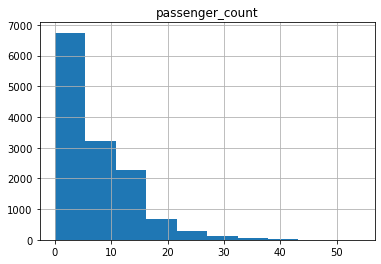

In [15]:
df.loc[df['vehicle_id'] == '6049'].hist('passenger_count')

array([[<AxesSubplot:title={'center':'passenger_count'}>]], dtype=object)

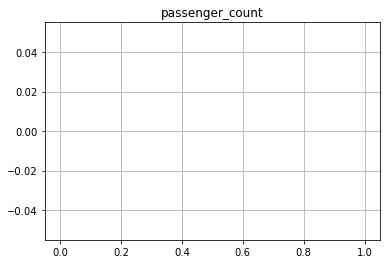

In [16]:
df.loc[df['vehicle_id'] == '5976'].hist('passenger_count')

## Drop rows we can't use

In [17]:
df.shape

(1767091, 14)

In [18]:
df['passenger_count'].value_counts(dropna=False)

NaN     1516437
0.0       42340
1.0       22864
2.0       19144
3.0       17035
4.0       15631
5.0       13643
6.0       13331
7.0       12375
8.0       11485
9.0       10208
10.0       9406
11.0       8395
12.0       7606
13.0       6793
14.0       5867
15.0       5184
16.0       4401
17.0       3746
18.0       3274
19.0       2836
20.0       2360
21.0       2026
22.0       1825
23.0       1514
24.0       1194
25.0       1082
26.0        864
27.0        688
28.0        613
29.0        471
30.0        412
31.0        384
32.0        245
33.0        244
34.0        218
35.0        155
37.0        138
36.0        135
38.0         69
39.0         65
40.0         50
41.0         49
43.0         48
42.0         38
45.0         38
48.0         23
47.0         22
49.0         19
50.0         18
44.0         16
51.0         13
46.0         12
52.0         11
53.0          9
54.0          8
55.0          6
57.0          5
61.0          2
58.0          1
Name: passenger_count, dtype: int64

In [19]:
df = df[df['passenger_count'].notna()]
df.shape

(250654, 14)

In [20]:
df = df[df['next_stop_id'].notna()]
df.shape

(161072, 14)

In [21]:
df['next_stop_id'].value_counts(dropna=False)

MTA_803054    8768
MTA_803002    8533
MTA_904920    4402
MTA_401787    2992
MTA_401738    2938
              ... 
MTA_404327     342
MTA_403831     318
MTA_401802     285
MTA_803019      18
MTA_405359      15
Name: next_stop_id, Length: 125, dtype: int64

In [22]:
df['passenger_count'].value_counts(dropna=False)

0.0     27058
1.0     13622
2.0     11135
3.0     10367
4.0      9896
6.0      8552
5.0      8376
7.0      8049
8.0      7380
9.0      6610
10.0     6121
11.0     5456
12.0     5198
13.0     4600
14.0     3939
15.0     3492
16.0     3022
17.0     2602
18.0     2280
19.0     1912
20.0     1620
21.0     1471
22.0     1271
23.0     1188
24.0      882
25.0      801
26.0      653
27.0      557
28.0      460
29.0      357
31.0      331
30.0      327
33.0      204
32.0      197
34.0      188
35.0      139
37.0      128
36.0      122
38.0       69
39.0       64
40.0       49
41.0       48
43.0       46
45.0       35
42.0       34
48.0       23
47.0       22
49.0       19
50.0       18
44.0       15
51.0       13
46.0       12
52.0       11
53.0        9
54.0        8
55.0        6
57.0        5
61.0        2
58.0        1
Name: passenger_count, dtype: int64

## Final check

In [23]:
df.shape

(161072, 14)

<AxesSubplot:>

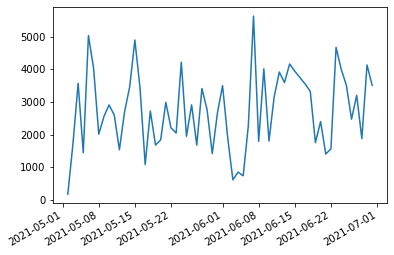

In [24]:
df['service_date'].value_counts(dropna=False).sort_index(ascending=True).plot()

array([[<AxesSubplot:title={'center':'passenger_count'}>]], dtype=object)

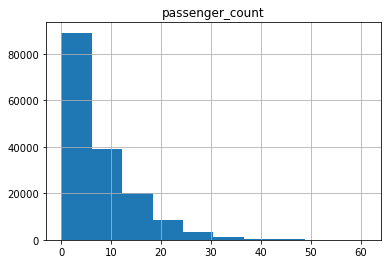

In [25]:
df.hist('passenger_count')

### Save an updated table

In [26]:
df.to_parquet(f'data/nyc_buses_with_passenger_counts_20210401_20210630_{route}_cleaned.parquet')